This IPython Notebook illustrates the use of the **`openmc.mgxs.Library`** class. The `Library` class is designed to automate the calculation of multi-group cross sections for use cases with one or more domains, cross section types, and/or nuclides. In particular, this Notebook illustrates the following features:

* Calculation of multi-energy-group and multi-delayed-group cross sections for a **fuel assembly**
* Automated creation, manipulation and storage of `MGXS` with **`openmc.mgxs.Library`**
* Steady-state pin-by-pin **delayed neutron fractions (beta)** for each delayed group.
* Generation of surface currents on the interfaces and surfaces of a Mesh.

## Generate Input Files

In [1]:
import math
import pickle

from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np

import openmc
import openmc.mgxs
import openmoc
import openmoc.process
from openmoc.opencg_compatible import get_openmoc_geometry
from openmoc.materialize import load_openmc_mgxs_lib

%matplotlib inline

/home/romano/miniconda3/envs/default/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


First we need to define materials that will be used in the problem. Before defining a material, we must create nuclides that are used in the material.

In [2]:
# Instantiate some Nuclides
h1 = openmc.Nuclide('H1')
b10 = openmc.Nuclide('B10')
o16 = openmc.Nuclide('O16')
u235 = openmc.Nuclide('U235')
u238 = openmc.Nuclide('U238')
zr90 = openmc.Nuclide('Zr90')

With the nuclides we defined, we will now create three materials for the fuel, water, and cladding of the fuel pins.

In [3]:
# 1.6 enriched fuel
fuel = openmc.Material(name='1.6% Fuel')
fuel.set_density('g/cm3', 10.31341)
fuel.add_nuclide(u235, 3.7503e-4)
fuel.add_nuclide(u238, 2.2625e-2)
fuel.add_nuclide(o16, 4.6007e-2)

# borated water
water = openmc.Material(name='Borated Water')
water.set_density('g/cm3', 0.740582)
water.add_nuclide(h1, 4.9457e-2)
water.add_nuclide(o16, 2.4732e-2)
water.add_nuclide(b10, 8.0042e-6)

# zircaloy
zircaloy = openmc.Material(name='Zircaloy')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_nuclide(zr90, 7.2758e-3)

With our three materials, we can now create a `Materials` object that can be exported to an actual XML file.

In [4]:
# Instantiate a Materials object
materials_file = openmc.Materials((fuel, water, zircaloy))
materials_file.default_xs = '71c'

# Export to "materials.xml"
materials_file.export_to_xml()

Now let's move on to the geometry. This problem will be a square array of fuel pins and control rod guide tubes for which we can use OpenMC's lattice/universe feature. The basic universe will have three regions for the fuel, the clad, and the surrounding coolant. The first step is to create the bounding surfaces for fuel and clad, as well as the outer bounding surfaces of the problem.

In [5]:
# Create cylinders for the fuel and clad
fuel_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, R=0.39218)
clad_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, R=0.45720)

# Create boundary planes to surround the geometry
min_x = openmc.XPlane(x0=-10.71, boundary_type='reflective')
max_x = openmc.XPlane(x0=+10.71, boundary_type='reflective')
min_y = openmc.YPlane(y0=-10.71, boundary_type='reflective')
max_y = openmc.YPlane(y0=+10.71, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-10., boundary_type='reflective')
max_z = openmc.ZPlane(z0=+10., boundary_type='reflective')

With the surfaces defined, we can now construct a fuel pin cell from cells that are defined by intersections of half-spaces created by the surfaces.

In [6]:
# Create a Universe to encapsulate a fuel pin
fuel_pin_universe = openmc.Universe(name='1.6% Fuel Pin')

# Create fuel Cell
fuel_cell = openmc.Cell(name='1.6% Fuel')
fuel_cell.fill = fuel
fuel_cell.region = -fuel_outer_radius
fuel_pin_universe.add_cell(fuel_cell)

# Create a clad Cell
clad_cell = openmc.Cell(name='1.6% Clad')
clad_cell.fill = zircaloy
clad_cell.region = +fuel_outer_radius & -clad_outer_radius
fuel_pin_universe.add_cell(clad_cell)

# Create a moderator Cell
moderator_cell = openmc.Cell(name='1.6% Moderator')
moderator_cell.fill = water
moderator_cell.region = +clad_outer_radius
fuel_pin_universe.add_cell(moderator_cell)

Likewise, we can construct a control rod guide tube with the same surfaces.

In [7]:
# Create a Universe to encapsulate a control rod guide tube
guide_tube_universe = openmc.Universe(name='Guide Tube')

# Create guide tube Cell
guide_tube_cell = openmc.Cell(name='Guide Tube Water')
guide_tube_cell.fill = water
guide_tube_cell.region = -fuel_outer_radius
guide_tube_universe.add_cell(guide_tube_cell)

# Create a clad Cell
clad_cell = openmc.Cell(name='Guide Clad')
clad_cell.fill = zircaloy
clad_cell.region = +fuel_outer_radius & -clad_outer_radius
guide_tube_universe.add_cell(clad_cell)

# Create a moderator Cell
moderator_cell = openmc.Cell(name='Guide Tube Moderator')
moderator_cell.fill = water
moderator_cell.region = +clad_outer_radius
guide_tube_universe.add_cell(moderator_cell)

Using the pin cell universe, we can construct a 17x17 rectangular lattice with a 1.26 cm pitch.

In [8]:
# Create fuel assembly Lattice
assembly = openmc.RectLattice(name='1.6% Fuel Assembly')
assembly.pitch = (1.26, 1.26)
assembly.lower_left = [-1.26 * 17. / 2.0] * 2

Next, we create a NumPy array of fuel pin and guide tube universes for the lattice.

In [9]:
# Create array indices for guide tube locations in lattice
template_x = np.array([5, 8, 11, 3, 13, 2, 5, 8, 11, 14, 2, 5, 8,
                       11, 14, 2, 5, 8, 11, 14, 3, 13, 5, 8, 11])
template_y = np.array([2, 2, 2, 3, 3, 5, 5, 5, 5, 5, 8, 8, 8, 8,
                       8, 11, 11, 11, 11, 11, 13, 13, 14, 14, 14])

# Initialize an empty 17x17 array of the lattice universes
universes = np.empty((17, 17), dtype=openmc.Universe)

# Fill the array with the fuel pin and guide tube universes
universes[:,:] = fuel_pin_universe
universes[template_x, template_y] = guide_tube_universe

# Store the array of universes in the lattice
assembly.universes = universes

OpenMC requires that there is a "root" universe. Let us create a root cell that is filled by the pin cell universe and then assign it to the root universe.

In [10]:
# Create root Cell
root_cell = openmc.Cell(name='root cell')
root_cell.fill = assembly

# Add boundary planes
root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z

# Create root Universe
root_universe = openmc.Universe(universe_id=0, name='root universe')
root_universe.add_cell(root_cell)

We now must create a geometry that is assigned a root universe and export it to XML.

In [11]:
# Create Geometry and set root Universe
geometry = openmc.Geometry()
geometry.root_universe = root_universe

In [12]:
# Export to "geometry.xml"
geometry.export_to_xml()

With the geometry and materials finished, we now just need to define simulation parameters. In this case, we will use 10 inactive batches and 40 active batches each with 2500 particles.

In [13]:
# OpenMC simulation parameters
batches = 50
inactive = 10
particles = 2500

# Instantiate a Settings object
settings_file = openmc.Settings()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles
settings_file.output = {'tallies': False}

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-10.71, -10.71, -10, 10.71, 10.71, 10.]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.source.Source(space=uniform_dist)

# Export to "settings.xml"
settings_file.export_to_xml()

Let us also create a `Plots` file that we can use to verify that our fuel assembly geometry was created successfully.

In [14]:
# Instantiate a Plot
plot = openmc.Plot(plot_id=1)
plot.filename = 'materials-xy'
plot.origin = [0, 0, 0]
plot.pixels = [250, 250]
plot.width = [-10.71*2, -10.71*2]
plot.color = 'mat'

# Instantiate a Plots object, add Plot, and export to "plots.xml"
plot_file = openmc.Plots([plot])
plot_file.export_to_xml()

With the plots.xml file, we can now generate and view the plot. OpenMC outputs plots in .ppm format, which can be converted into a compressed format like .png with the convert utility.

In [15]:
# Run openmc in plotting mode
openmc.plot_geometry(output=False)

0

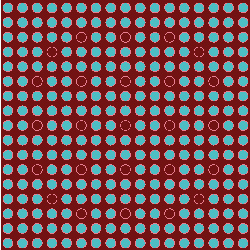

In [16]:
# Convert OpenMC's funky ppm to png
!convert materials-xy.ppm materials-xy.png

# Display the materials plot inline
Image(filename='materials-xy.png')

As we can see from the plot, we have a nice array of fuel and guide tube pin cells with fuel, cladding, and water!

## Create an MGXS Library

Now we are ready to generate multi-group cross sections! First, let's define 20-energy-group, 1-energy-group, and 6-delayed-group structures.

In [17]:
# Instantiate a 20-group EnergyGroups object
energy_groups = openmc.mgxs.EnergyGroups()
energy_groups.group_edges = np.logspace(-3, 7.3, 21)

# Instantiate a 1-group EnergyGroups object
one_group = openmc.mgxs.EnergyGroups()
one_group.group_edges = np.array([energy_groups.group_edges[0], energy_groups.group_edges[-1]])

# Instantiate a 6-delayed-group list
delayed_groups = list(range(1,7))

Next, we will instantiate an `openmc.mgxs.Library` for the energy and delayed groups with our the fuel assembly geometry.

In [18]:
# Instantiate a tally mesh                                                                                                                                                                  
mesh = openmc.Mesh(mesh_id=1)
mesh.type = 'regular'
mesh.dimension = [17, 17, 1]
mesh.lower_left = [-10.71, -10.71, -10000.]
mesh.width = [1.26, 1.26, 20000.]

# Initialize an 20-energy-group and 6-delayed-group MGXS Library
mgxs_lib = openmc.mgxs.Library(geometry)
mgxs_lib.energy_groups  = energy_groups
mgxs_lib.delayed_groups = delayed_groups

# Specify multi-group cross section types to compute
mgxs_lib.mgxs_types = ['total', 'transport', 'nu-scatter matrix', 'kappa-fission', 'inverse-velocity', 'chi-prompt',
                      'prompt-nu-fission', 'chi-delayed', 'delayed-nu-fission', 'beta']

# Specify a "mesh" domain type for the cross section tally filters
mgxs_lib.domain_type = 'mesh'

# Specify the mesh domain over which to compute multi-group cross sections
mgxs_lib.domains = [mesh]

# Construct all tallies needed for the multi-group cross section library
mgxs_lib.build_library()

# Create a "tallies.xml" file for the MGXS Library
tallies_file = openmc.Tallies()
mgxs_lib.add_to_tallies_file(tallies_file, merge=True)

# Instantiate a current tally
mesh_filter = openmc.MeshFilter(mesh)
current_tally = openmc.Tally(name='current tally')
current_tally.scores = ['current']
current_tally.filters = [mesh_filter]

# Add current tally to the tallies file
tallies_file.append(current_tally)

# Export to "tallies.xml"
tallies_file.export_to_xml()

Now, we can run OpenMC to generate the cross sections.

In [19]:
# Run OpenMC
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

## Tally Data Processing

Our simulation ran successfully and created statepoint and summary output files. We begin our analysis by instantiating a `StatePoint` object. 

In [20]:
# Load the last statepoint file
sp = openmc.StatePoint('statepoint.50.h5')

The statepoint is now ready to be analyzed by the `Library`. We simply have to load the tallies from the statepoint into the `Library` and our `MGXS` objects will compute the cross sections for us under-the-hood.

In [21]:
# Initialize MGXS Library with OpenMC statepoint data
mgxs_lib.load_from_statepoint(sp)

# Extrack the current tally separately
current_tally = sp.get_tally(name='current tally')

# Using Tally Arithmetic to Compute the Delayed Neutron Precursor Concentrations

Finally, we illustrate how one can leverage OpenMC's [tally arithmetic](https://mit-crpg.github.io/openmc/pythonapi/examples/tally-arithmetic.html) data processing feature with `MGXS` objects. The `openmc.mgxs` module uses tally arithmetic to compute multi-group cross sections with automated uncertainty propagation. Each `MGXS` object includes an `xs_tally` attribute which is a "derived" `Tally` based on the tallies needed to compute the cross section type of interest. These derived tallies can be used in subsequent tally arithmetic operations. For example, we can use tally artithmetic to compute the delayed neutron precursor concentrations using the `Beta` and `DelayedNuFissionXS` objects. The delayed neutron precursor concentrations are modeled using the following equations:

$$\frac{\partial}{\partial t} C_{k,d} (t) = \int_{0}^{\infty}\mathrm{d}E'\int_{\mathbf{r} \in V_{k}}\mathrm{d}\mathbf{r} \beta_{k,d} (t) \nu_d \sigma_{f,x}(\mathbf{r},E',t)\Phi(\mathbf{r},E',t) - \lambda_{d} C_{k,d} (t) $$

$$C_{k,d} (t=0) = \frac{1}{\lambda_{d}} \int_{0}^{\infty}\mathrm{d}E'\int_{\mathbf{r} \in V_{k}}\mathrm{d}\mathbf{r} \beta_{k,d} (t=0) \nu_d \sigma_{f,x}(\mathbf{r},E',t=0)\Phi(\mathbf{r},E',t=0) $$

In [22]:
# Set the time constants for the delayed precursors (in seconds^-1)
precursor_halflife = np.array([55.6, 24.5, 16.3, 2.37, 0.424, 0.195])
precursor_lambda = -np.log(0.5) / precursor_halflife

beta = mgxs_lib.get_mgxs(mesh, 'beta')

# Create a tally object with only the delayed group filter for the time constants
beta_filters = [f for f in beta.xs_tally.filters if type(f) is not openmc.DelayedGroupFilter]
lambda_tally = beta.xs_tally.summation(nuclides=beta.xs_tally.nuclides)
for f in beta_filters:
    lambda_tally = lambda_tally.summation(filter_type=type(f), remove_filter=True) * 0. + 1.

# Set the mean of the lambda tally and reshape to account for nuclides and scores
lambda_tally._mean = precursor_lambda
lambda_tally._mean.shape = lambda_tally.std_dev.shape

# Set a total nuclide and lambda score
lambda_tally.nuclides = [openmc.Nuclide(name='total')]
lambda_tally.scores = ['lambda']

delayed_nu_fission = mgxs_lib.get_mgxs(mesh, 'delayed-nu-fission')

# Use tally arithmetic to compute the precursor concentrations
precursor_conc = beta.xs_tally.summation(filter_type=openmc.EnergyFilter, remove_filter=True) * \
    delayed_nu_fission.xs_tally.summation(filter_type=openmc.EnergyFilter, remove_filter=True) / lambda_tally
    
# The difference is a derived tally which can generate Pandas DataFrames for inspection
precursor_conc.get_pandas_dataframe().head(10)

mesh 1       delayedgroup nuclide  \
       x  y  z                        
0      1  1  1            1   total   
1      1  1  1            2   total   
2      1  1  1            3   total   
3      1  1  1            4   total   
4      1  1  1            5   total   
5      1  1  1            6   total   
6      1  2  1            1   total   
7      1  2  1            2   total   
8      1  2  1            3   total   
9      1  2  1            4   total   

                                               score      mean std. dev.  
                                                                          
0  (((delayed-nu-fission / nu-fission) * (delayed...  0.002406  0.000557  
1  (((delayed-nu-fission / nu-fission) * (delayed...  0.000937  0.000073  
2  (((delayed-nu-fission / nu-fission) * (delayed...  0.007412  0.000841  
3  (((delayed-nu-fission / nu-fission) * (delayed...  0.072924  0.005015  
4  (((delayed-nu-fission / nu-fission) * (delayed...  0.034008  0.002213  
5  (((delayed-nu-fission / nu-fission) * (delayed...  0.002561  0.000366  
6  (((delayed-nu-fission / nu-fission) * (delayed...  0.011966  0.004607  
7  (((delayed-nu-fission / nu-fission) * (delayed...  0.000917  0.000075  
8  (((delayed-nu-fission / nu-fission) * (delayed...  0.007980  0.000879  
9  (((delayed-nu-fission / nu-fission) * (delayed...  0.084940  0.005351

Another useful feature of the Python API is the ability to extract the surface currents for the interfaces and surfaces of a mesh. We can inspect the currents for the mesh by getting the pandas dataframe.

In [23]:
current_tally.get_pandas_dataframe().head(10)

mesh 1          surface nuclide    score     mean std. dev.
       x  y  z                                               
0      1  1  1  x-min out   total  current  0.00000  0.000000
1      1  1  1  x-max out   total  current  0.00000  0.000000
2      1  1  1  y-min out   total  current  0.02985  0.000678
3      1  1  1  y-max out   total  current  0.03023  0.000637
4      1  1  1  z-min out   total  current  0.00000  0.000000
5      1  1  1  z-max out   total  current  0.00000  0.000000
6      1  1  1   x-min in   total  current  0.03085  0.000628
7      1  1  1   x-max in   total  current  0.03058  0.000609
8      1  1  1   y-min in   total  current  0.00000  0.000000
9      1  1  1   y-max in   total  current  0.00000  0.000000

## Cross Section Visualizations

In addition to inspecting the data in the tallies by getting the pandas dataframe, we can also plot the tally data on the domain mesh. Below is the delayed neutron fraction tallied in each mesh cell for each delayed group.

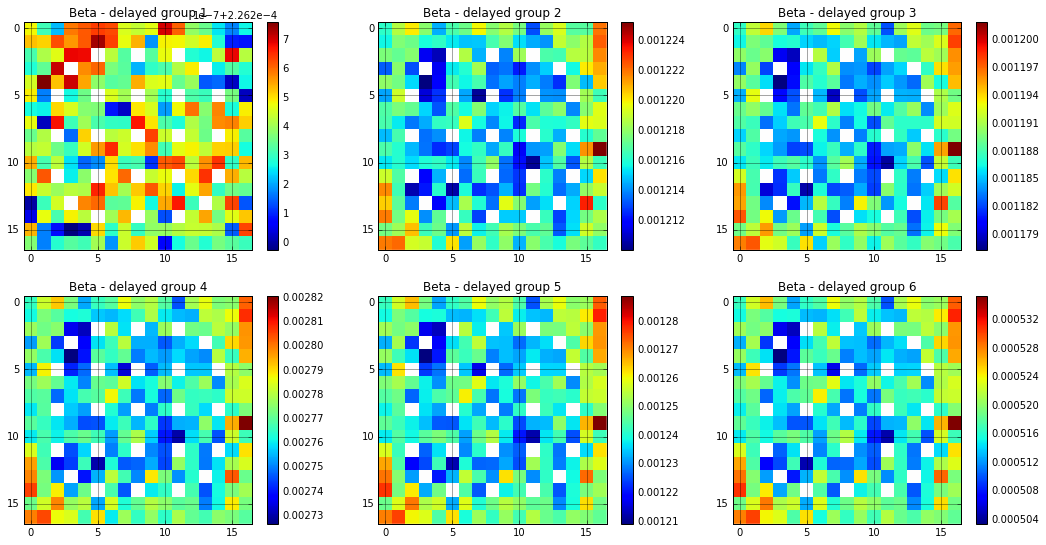

In [24]:
# Extract the energy-condensed delayed neutron fraction tally
beta_by_group = beta.get_condensed_xs(one_group).xs_tally.summation(filter_type='energy', remove_filter=True)
beta_by_group.mean.shape = (17, 17, 6)
beta_by_group.mean[beta_by_group.mean == 0] = np.nan

# Plot the betas
plt.figure(figsize=(18,9))
fig = plt.subplot(231)
plt.imshow(beta_by_group.mean[:,:,0], interpolation='none', cmap='jet')
plt.colorbar()
plt.title('Beta - delayed group 1')

fig = plt.subplot(232)
plt.imshow(beta_by_group.mean[:,:,1], interpolation='none', cmap='jet')
plt.colorbar()
plt.title('Beta - delayed group 2')

fig = plt.subplot(233)
plt.imshow(beta_by_group.mean[:,:,2], interpolation='none', cmap='jet')
plt.colorbar()
plt.title('Beta - delayed group 3')

fig = plt.subplot(234)
plt.imshow(beta_by_group.mean[:,:,3], interpolation='none', cmap='jet')
plt.colorbar()
plt.title('Beta - delayed group 4')

fig = plt.subplot(235)
plt.imshow(beta_by_group.mean[:,:,4], interpolation='none', cmap='jet')
plt.colorbar()
plt.title('Beta - delayed group 5')

fig = plt.subplot(236)
plt.imshow(beta_by_group.mean[:,:,5], interpolation='none', cmap='jet')
plt.colorbar()
plt.title('Beta - delayed group 6')